## Import Labraries

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cart
import cartopy.io.img_tiles as cimgt
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import calendar

## Open the dataset

## For this assignment I am using Sea Surface Temperature for 2023.

In [4]:
ds = r'data4rafael.nc'
ds = xr.open_dataset(ds)
ds

<xarray.Dataset> Size: 829MB
Dimensions:     (valid_time: 716, latitude: 201, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2023-01-01 ... 2023-12-30T12:...
  * latitude    (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 40.5 40.25 40.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver      (valid_time) <U4 11kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-12T15:02 GRIB to CDM+CF via cfgrib-0.9.1...

## Groupby Monthly mean

In [5]:
ds_monthly = ds.resample(valid_time='ME').mean()
ds_month = ds.groupby('valid_time.month').mean()
ds_month

<xarray.Dataset> Size: 14MB
Dimensions:    (month: 12, latitude: 201, longitude: 1440)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 40.5 40.25 40.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst        (month, latitude, longitude) float32 14MB 271.5 271.5 ... 290.4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-12T15:02 GRIB to CDM+CF via cfgrib-0.9.1...

## Convert the temperature from Kelvin to Celsius

In [5]:
# Convert the temperature from Kelvin to Celsius
ds_month_celsius = ds_month - 273.15
ds_month_celsius.attrs['units'] = '°C'
ds_month_celsius

<xarray.Dataset> Size: 14MB
Dimensions:    (latitude: 201, longitude: 1440, month: 12)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 40.5 40.25 40.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst        (month, latitude, longitude) float32 14MB -1.69 -1.69 ... 17.21
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-12T15:02 GRIB to CDM+CF via cfgrib-0.9.1...
    units:                   °C

## Checking the range variation

In [6]:
max_temp = ds_month_celsius['sst'].max()
print(max_temp)

<xarray.DataArray 'sst' ()> Size: 4B
np.float32(29.88507)
Coordinates:
    number   int64 8B 0


In [7]:
min_temp = ds_month_celsius['sst'].min()
print(min_temp)

<xarray.DataArray 'sst' ()> Size: 4B
np.float32(-3.0461426)
Coordinates:
    number   int64 8B 0


## Plotting the subsets maps

Text(0.5, 0.98, 'Sea Surface Temperature - North Slope of Alaska')

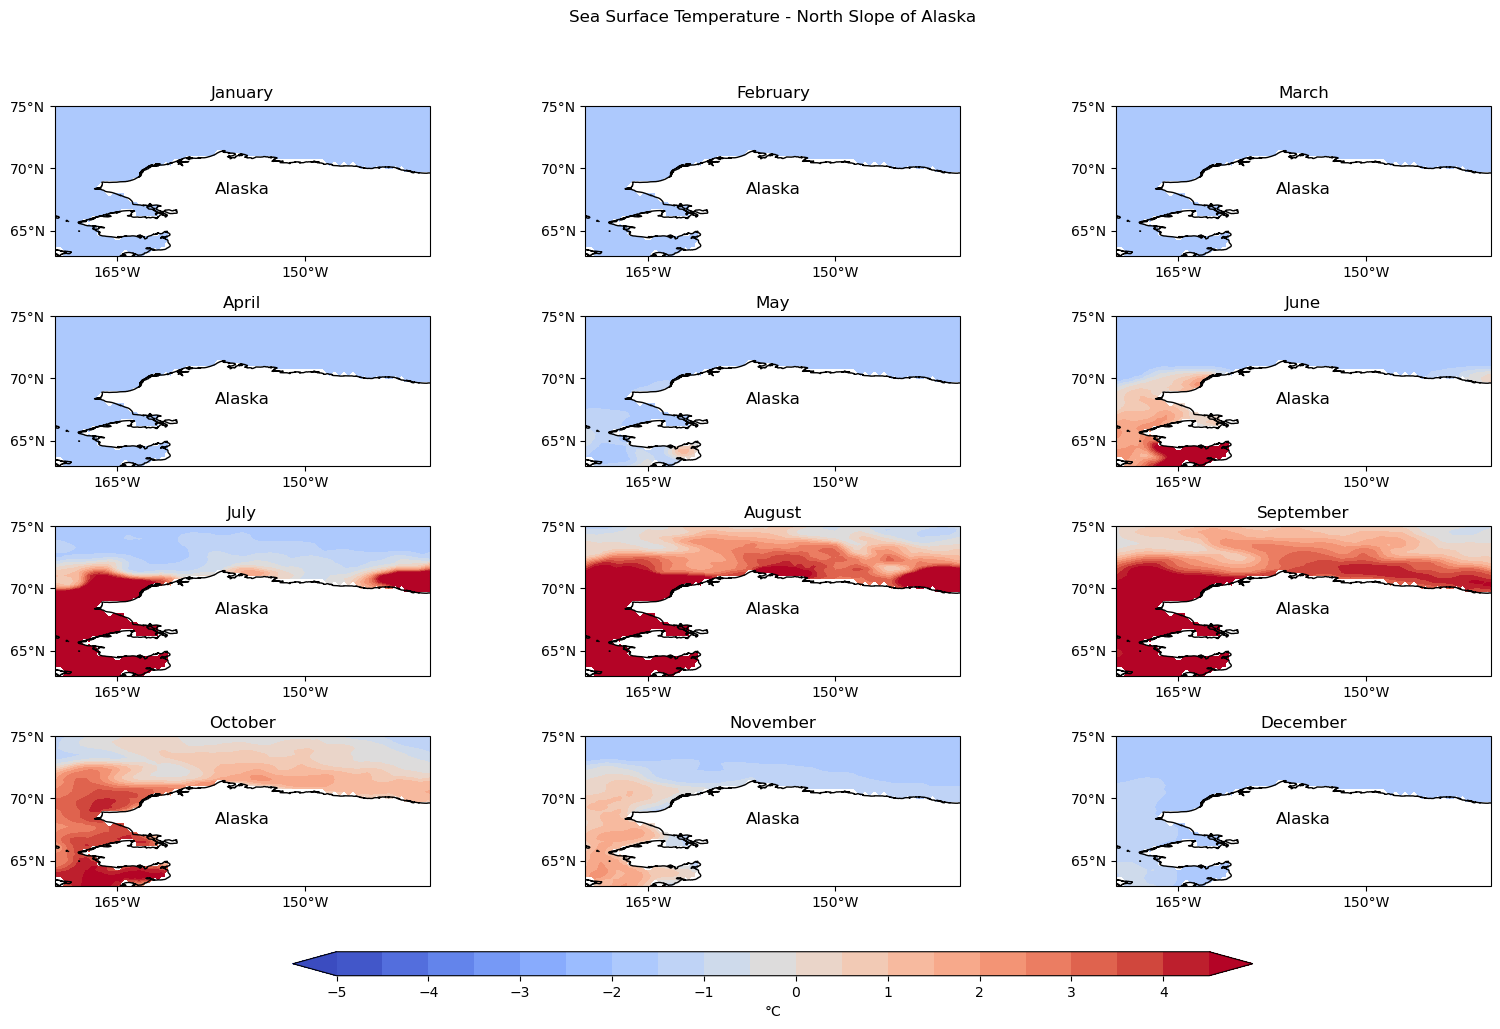

In [11]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=4, ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 12))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

clevs = np.arange(-5, 5, 0.5)

# Loop over all of the months and plot
for i, month in enumerate(ds_month_celsius['month']):

    # Select the month
    data = ds_month_celsius['sst'].sel(month=month)

    # Add the cyclic point
    data, lons = add_cyclic_point(data, coord=ds_month_celsius['longitude'])

    # Contour plot
    cs = axs[i].contourf(lons, ds_month['latitude'], data, clevs,
                         transform=ccrs.PlateCarree(),
                         cmap='coolwarm', extend='both')

    # Longitude labels
    axs[i].set_xticks(np.arange(-180, -140, 15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(60, 81, 5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)

    # Title each subplot with the name of the month
    month_name = calendar.month_name[month.values]
    axs[i].set_title(month_name)

    # Draw the coastlines for each subplot
    axs[i].coastlines()

    # Set the extent to focus on Alaska
    axs[i].set_extent([-170, -140, 63, 75], crs=ccrs.PlateCarree())
    
    # Add label "Alaska"
    axs[i].text(-155, 68, 'Alaska', horizontalalignment='center',
                transform=ccrs.PlateCarree(), fontsize=12, color='black')

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.4, hspace=0.4)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='\u00b0C')

# Add a big title at the top
plt.suptitle('Sea Surface Temperature - North Slope of Alaska')